In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
base_dir='E:\chest_xray'
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
sample_image_pneumonia=os.listdir(os.path.join(train_dir,'PNEUMONIA'))
sample_image_healthy=os.listdir(os.path.join(train_dir,'NORMAL'))

In [3]:
class callbacka(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.91):
            print("\nLoss is low stopping trainng")
            self.model.stop_training=True

In [4]:
mcallbacks=callbacka()

In [5]:
img_size=110

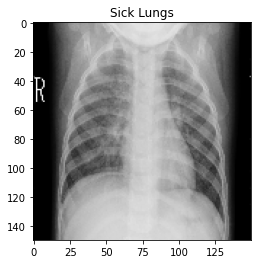

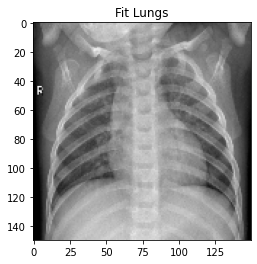

In [6]:
sample_image_pnue=sample_image_pneumonia[randint(0,(len(sample_image_pneumonia)-1))]
sample_image_normal=sample_image_healthy[randint(0,(len(sample_image_healthy)-1))]

img_to_array_sick=cv2.imread(os.path.join(os.path.join(train_dir,'PNEUMONIA'),sample_image_pnue))
img_to_array_fit=cv2.imread(os.path.join(os.path.join(train_dir,'NORMAL'),sample_image_normal))

plt.imshow(cv2.resize(img_to_array_sick,(150,150)))
plt.title("Sick Lungs")
plt.show()

plt.imshow(cv2.resize(img_to_array_fit,(150,150)))
plt.title("Fit Lungs")
plt.show()

In [9]:
def get_train_generator(image_dir):
    
    image_generator = ImageDataGenerator(
        rescale = 1./255,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        samplewise_center=True,samplewise_std_normalization=True)
    
    
        
    generator = image_generator.flow_from_directory(train_dir,batch_size=5,class_mode='binary',target_size=(img_size,img_size),shuffle=True)
    return generator

In [8]:
def get_test_generator(train_dir,test_dir):
    
    stats_train_generator= ImageDataGenerator().flow_from_directory(directory=train_dir,batch_size=200,shuffle=True,target_size=(img_size,img_size))
    batch = stats_train_generator.next()
    data_sample=batch[0]
    
    test_datagen = ImageDataGenerator(rescale = 1./255,featurewise_center=True,featurewise_std_normalization=True)
    test_datagen.fit(data_sample)
    valid_generator=test_datagen.flow_from_directory(test_dir,batch_size=10,class_mode='binary',target_size=(img_size,img_size),shuffle=False)
    return valid_generator      

In [10]:
train_generator = get_train_generator(train_dir)
valid_generator = get_test_generator(train_dir,test_dir)

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0


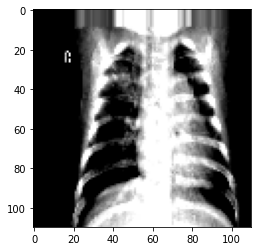

In [11]:
x, y = train_generator.__getitem__(0)
print(y[0])
plt.imshow(x[0])

-7.061919e-08
0.9999959


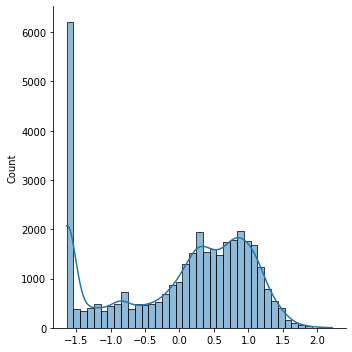

In [12]:
import seaborn as sns
sns.displot(x[0].ravel(),kde=True)
print(np.mean(x[0]))
print(np.std(x[0]))

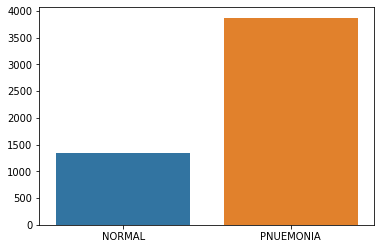

In [13]:
labels=['NORMAL','PNUEMONIA']
frequency=[list(train_generator.labels).count(0),list(train_generator.labels).count(1)]
sns.barplot(x=labels,y=frequency)
plt.show()

In [14]:
type(train_generator.labels)

numpy.ndarray

In [15]:
from sklearn.utils import class_weight

In [16]:
y_unique=np.unique(train_generator.labels)
y_train=train_generator.labels
class_weights=class_weight.compute_class_weight('balanced',y_unique,y_train)
class_weights=dict(enumerate(class_weights))

D:\Python_Anaconda\envs\my_pi\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [17]:
print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [18]:
def build_model():
    pre_trained_model=DenseNet121(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')

    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer=pre_trained_model.get_layer('conv3_block12_concat')
    last_output=last_layer.output
    x=layers.Flatten()(last_output)
    x=layers.Dense(512,activation='relu')(x)
    x=layers.Dropout(0.2)(x)
    predictions =layers.Dense(1,activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [19]:
model=build_model()

In [20]:
history=model.fit(train_generator,validation_data=valid_generator,class_weight=class_weights,steps_per_epoch=134,epochs=20,validation_steps=60,verbose=2,callbacks=[mcallbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 134 steps, validate for 60 steps
Epoch 1/20
134/134 - 55s - loss: 4.5949 - accuracy: 0.6922 - val_loss: 3.9466 - val_accuracy: 0.7367
Epoch 2/20
134/134 - 53s - loss: 2.6166 - accuracy: 0.7657 - val_loss: 10.7605 - val_accuracy: 0.6150
Epoch 3/20
134/134 - 52s - loss: 0.9077 - accuracy: 0.8463 - val_loss: 1.3569 - val_accuracy: 0.7600
Epoch 4/20

Loss is low stopping trainng
134/134 - 52s - loss: 0.4546 - accuracy: 0.8612 - val_loss: 0.2524 - val_accuracy: 0.9250


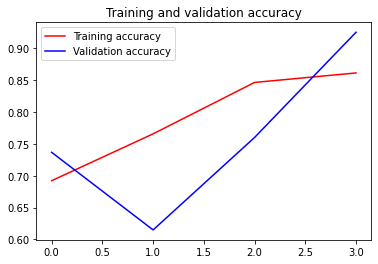

<Figure size 432x288 with 0 Axes>

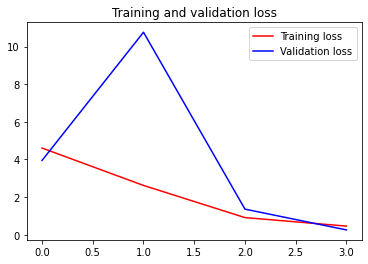

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs,loss, 'r', label="Training loss")
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
predicted_vals_test = model.predict(valid_generator, steps = len(valid_generator))

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
fpr,tpr,threshold_roc=roc_curve(valid_generator.labels,predicted_vals_test)

In [26]:
precision,recall,threshold_pr=precision_recall_curve(valid_generator.labels,predicted_vals_test)

In [27]:
import pandas as pd

In [28]:
from sklearn.metrics import accuracy_score
accuracy_ls=[]
for thresh in threshold_roc:
    y_pred=np.where(predicted_vals_test>thresh,1,0)
    accuracy_ls.append(accuracy_score(valid_generator.labels,y_pred,))
accuracy_scores=pd.concat([pd.Series(threshold_roc),pd.Series(fpr),pd.Series(tpr),pd.Series(accuracy_ls)],axis=1)
accuracy_scores.columns=['THRESHOLD','FALSE POSITIVE RATE','TRUE POSITIVE RATE','ACCURACY_SCORE']
accuracy_scores.sort_values(by='ACCURACY_SCORE',ascending=False,inplace=True)

In [29]:
accuracy_scores.head()

,THRESHOLD,FALSE POSITIVE RATE,TRUE POSITIVE RATE,ACCURACY_SCORE
43,0.437273,0.111111,0.956410,0.932692
44,0.437067,0.111111,0.958974,0.931090
42,0.450921,0.106838,0.956410,0.931090
45,0.410227,0.128205,0.958974,0.927885
41,0.465686,0.106838,0.946154,0.927885


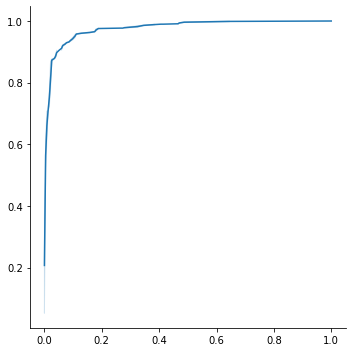

In [30]:
sns.relplot(x=fpr,y=tpr,kind='line')
plt.show()

In [31]:
accuracy_ls_pr=[]
for thresh in threshold_pr:
    y_pred=np.where(predicted_vals_test>thresh,1,0)
    accuracy_ls_pr.append(accuracy_score(valid_generator.labels,y_pred,))
accuracy_scores_pr=pd.concat([pd.Series(threshold_pr),pd.Series(precision),pd.Series(recall),pd.Series(accuracy_ls_pr)],axis=1)
accuracy_scores_pr.columns=['THRESHOLD','FALSE POSITIVE RATE','TRUE POSITIVE RATE','ACCURACY_SCORE']
accuracy_scores_pr.sort_values(by='ACCURACY_SCORE',ascending=False,inplace=True)

In [32]:
accuracy_scores_pr.head()

,THRESHOLD,FALSE POSITIVE RATE,TRUE POSITIVE RATE,ACCURACY_SCORE
138,0.426637,0.932668,0.958974,0.932692
140,0.437273,0.934837,0.956410,0.932692
137,0.425683,0.930348,0.958974,0.931090
139,0.437067,0.935000,0.958974,0.931090
141,0.450921,0.937186,0.956410,0.931090


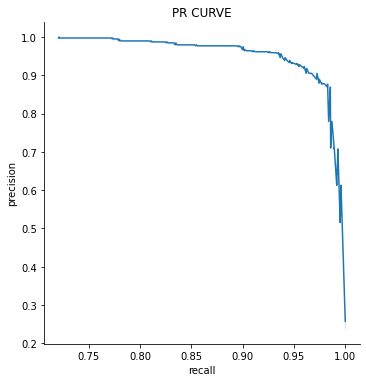

In [33]:
sns.relplot(x=precision,y=recall,kind='line')
plt.title('PR CURVE')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [34]:
model.save('CHEST_NET_121_CNN.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CHEST_NET_121_CNN.model\assets


In [35]:
accuracy_scores.to_csv('AUC_ROC_SCORES.csv')